In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

Using matplotlib backend: TkAgg


# Lab 3 Report
## Ian Eykamp
Lab group: Ian Eykamp, Lauren Xiong, Melissa Kazazic

## Initial Testing
Our PCB worked correctly on all start-up tests. We took one sweep of the gate voltage on the MOSFET (Vg) when the potentiometer was fully to the right (maximizing V_COMP). As expected, the gate voltage followed a square wave with a 50% duty cycle, which is the maximum duty cycle for the UC2844.

running helper


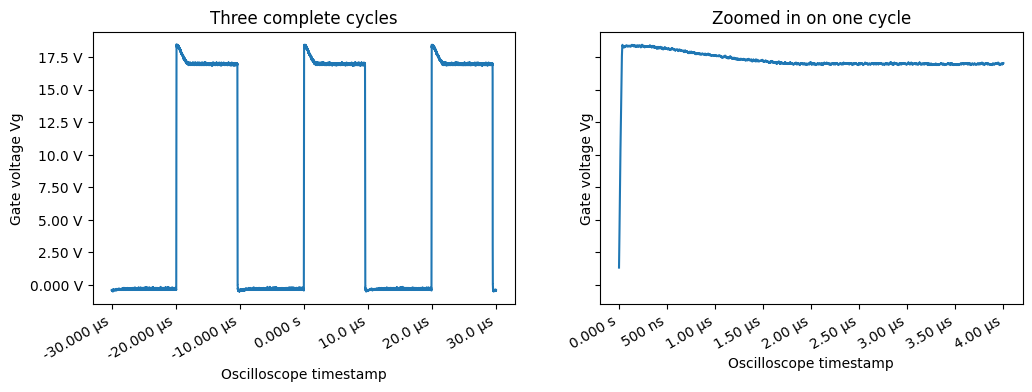

In [30]:
(df, tspan, tstep) = helper.read_rigol_csv("Initial_power_on.csv", ch1 = "Vg")
df_envelope = df
df_zoom = df[(df["t"] > 0) & (df["t"] < 4e-6)]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Gate voltage Vg", "V", title = "Three complete cycles", ax = ax1)
ax1.plot(df_envelope["t"], df_envelope["Vg"], label = "Vg")

ax2.plot(df_zoom["t"], df_zoom["Vg"], label = "Vg")
helper.axes_labels("Oscilloscope timestamp", "s", "Gate voltage Vg", "V", title = "Zoomed in on one cycle", ax = ax2)

There is an unexpected peak in the gate voltage at the start of each on cycle. A close examination reveals a linear ramp down from the peak gate voltage of 18V down to about 17V over the course of 1.5us. There does not appear to be any ripple during this transition. A possible explanation for this behavior is the capacitance of the oxide of the semiconductor as it charges to full capacity and as a voltage drop develops across the gate resistor (though I doubt this explanation).

In [59]:
# Task 3 csv files: Vshunt and Vdrain
(df_task3_4V, tspan, tstep) = helper.read_rigol_csv("Task3_4Vout.csv", ch1 = "Vsh_4V", ch2 = "Vd_4V")
(df_task3_7V, tspan, tstep) = helper.read_rigol_csv("Task3_7Vout.csv", ch1 = "Vsh_7V", ch2 = "Vd_7V")
(df_task3_9V, tspan, tstep) = helper.read_rigol_csv("Task3_9Vout.csv", ch1 = "Vsh_9V", ch2 = "Vd_9V")

# Task 4 csv files: Vgdr and Vg
(df_task4_4V, tspan, tstep) = helper.read_rigol_csv("Task4_4Vout.csv", ch1 = "Vgdr_4V", ch2 = "Vg_4V")
(df_task4_7V, tspan, tstep) = helper.read_rigol_csv("Task4_7Vout.csv", ch1 = "Vgdr_7V", ch2 = "Vg_7V")
(df_task4_9V, tspan, tstep) = helper.read_rigol_csv("Task4_9Vout.csv", ch1 = "Vgdr_9V", ch2 = "Vg_9V")

# Combine all variables into one for convenience
df = df_task3_4V.set_index("t").join([df_task3_7V.set_index("t"), df_task3_9V.set_index("t"), df_task4_4V.set_index("t"), df_task4_7V.set_index("t"), df_task4_9V.set_index("t")]).reset_index()


running helper
running helper
running helper
running helper
running helper
running helper


## Characterization
The potentiometer was tuned to adjust the duty cycle until the average output voltage was 4V, 7V, and 9V, respectively. The voltage at four nodes was measured: the voltage across the shunt resistor Vshunt = `Vsh`, the voltage at the MOSFET drain (upstream end) Vdrain = `Vd`, the MOSFET gate voltage Vgate = `Vg`, and the voltage on the UC2844 gate driver pin `Vgdr`. Representative sweeps are plotted below.

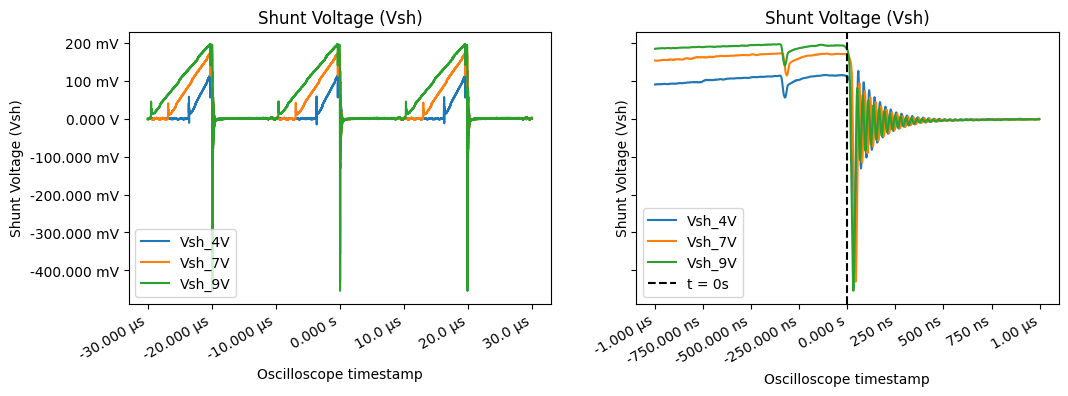

In [81]:
# Vshunt
df_envelope = df
df_zoom = df[(df["t"] > -1e-6) & (df["t"] < 1e-6)]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh)", ax = ax1)
ax1.plot(df_envelope["t"], df_envelope["Vsh_4V"], label = "Vsh_4V")
ax1.plot(df_envelope["t"], df_envelope["Vsh_7V"], label = "Vsh_7V")
ax1.plot(df_envelope["t"], df_envelope["Vsh_9V"], label = "Vsh_9V")
ax1.legend(loc = "lower left")

helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh)", ax = ax2)
ax2.plot(df_zoom["t"], df_zoom["Vsh_4V"], label = "Vsh_4V")
ax2.plot(df_zoom["t"], df_zoom["Vsh_7V"], label = "Vsh_7V")
ax2.plot(df_zoom["t"], df_zoom["Vsh_9V"], label = "Vsh_9V")
plt.axvline(x = 0, color = "black", linestyle = "dashed", label = "t = 0s")
ax2.legend(loc = "lower left")

From the left figure, the power converter is clearly in discontinuous conduction mode. The shunt voltage is small relative to other voltages in the system, reaching a maximum of ~200mV at the peak of the 50% duty cycle. Since the shunt resistor is 0.05 Ohm, this means the peak output current is $\frac{200mV}{50 m\Omega} \approx 4.0A$.

The current ramps up linearly from when the the gate is turned on until the shunt voltage exceeds the threshold VCOMP set by the potentiometer. The oscilloscope centered all voltage sweeps on the falling edge of Vshunt; however, it might be more accurate to shift them such that the start of the ramps all line up, since this is what we call the start of the cycle, every $\frac{1.72}{2 \cdot R_T C_T}\approx 20 \mu s$.

Non-idealities:
* Immediately after the gate is shut off, the shunt voltage shows a violent, rapidly decaying ring (maximum amplitude -400mV, period <50ns, time constant ~100ns).
* About 300ns before the gate voltage is shut off, there is a brief ~50mV dip in the shunt voltage.
* Shortly after the gate turns on (Vshunt starts to ramp up), there is a brief ~50mV spike in the shunt voltage. I suspect this is caused by the same mechanism as the 50mV dip above.

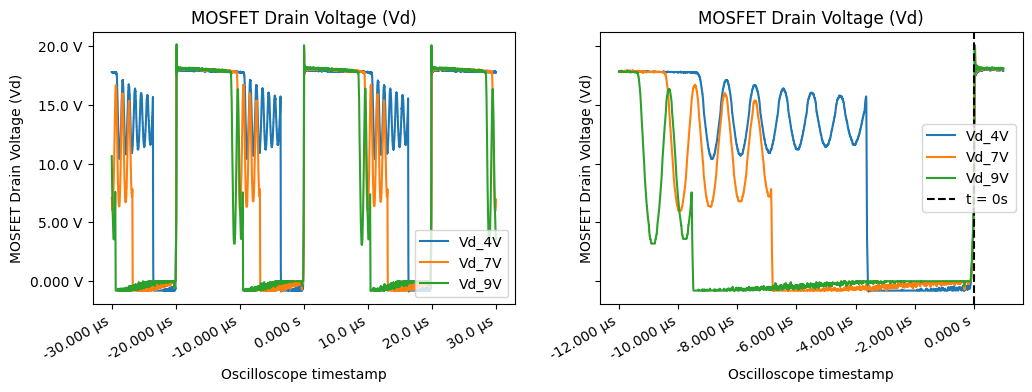

In [80]:
# Vdrain
df_envelope = df
df_zoom = df[(df["t"] > -12e-6) & (df["t"] < 1e-6)]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Drain Voltage (Vd)", "V", title = "MOSFET Drain Voltage (Vd)", ax = ax1)
ax1.plot(df_envelope["t"], df_envelope["Vd_4V"], label = "Vd_4V")
ax1.plot(df_envelope["t"], df_envelope["Vd_7V"], label = "Vd_7V")
ax1.plot(df_envelope["t"], df_envelope["Vd_9V"], label = "Vd_9V")
ax1.legend(loc = "lower right")

helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Drain Voltage (Vd)", "V", title = "MOSFET Drain Voltage (Vd)", ax = ax2)
ax2.plot(df_zoom["t"], df_zoom["Vd_4V"], label = "Vd_4V")
ax2.plot(df_zoom["t"], df_zoom["Vd_7V"], label = "Vd_7V")
ax2.plot(df_zoom["t"], df_zoom["Vd_9V"], label = "Vd_9V")
plt.axvline(x = 0, color = "black", linestyle = "dashed", label = "t = 0s")
ax2.legend(loc = "center right")

The MOSFET drain voltage is relatively constant at 18V while the gate is turned off, during which point current is sourced by the inductor through the diode. Once the inductor runs out of charge, the voltage on this node oscillates continually until the gate is turned on again, and the drain voltage drops to approximately zero. The oscillation has a period of half a microsecond and a negligible rate of decay. The peak-to-trough amplitude depends on the output voltage and is larger for higher duty cycles. Noticeably, the oscillation continues for longer at lower cutoff currents, corresponding to a longer period between conduction cycles.

Non-idealities:
* Minor +2V spike on the rising edge of Vdrain when the MOSFET is turned off.
* Unexpected ring during non-conducting part of cycle, as described above.

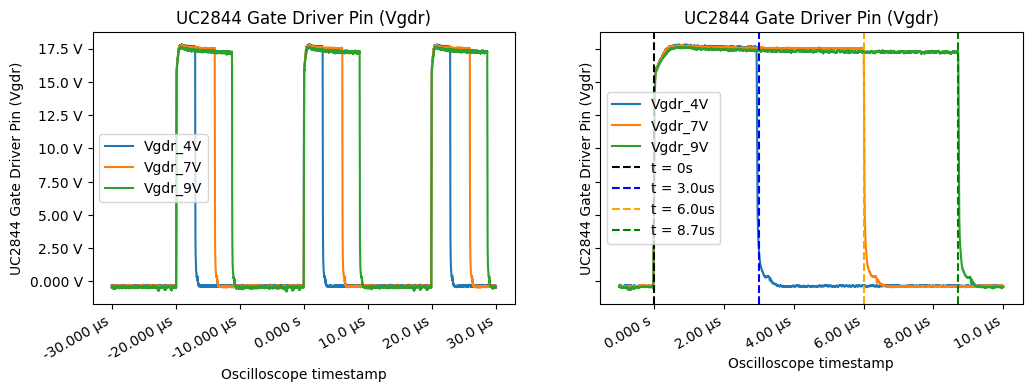

In [92]:
# Vgdr
df_envelope = df
df_zoom = df[(df["t"] > -1e-6) & (df["t"] < 10e-6)]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "UC2844 Gate Driver Pin (Vgdr)", "V", title = "UC2844 Gate Driver Pin (Vgdr)", ax = ax1)
ax1.plot(df_envelope["t"], df_envelope["Vgdr_4V"], label = "Vgdr_4V")
ax1.plot(df_envelope["t"], df_envelope["Vgdr_7V"], label = "Vgdr_7V")
ax1.plot(df_envelope["t"], df_envelope["Vgdr_9V"], label = "Vgdr_9V")
ax1.legend(loc = "center left")

helper.axes_labels("Oscilloscope timestamp", "s", "UC2844 Gate Driver Pin (Vgdr)", "V", title = "UC2844 Gate Driver Pin (Vgdr)", ax = ax2)
ax2.plot(df_zoom["t"], df_zoom["Vgdr_4V"], label = "Vgdr_4V")
ax2.plot(df_zoom["t"], df_zoom["Vgdr_7V"], label = "Vgdr_7V")
ax2.plot(df_zoom["t"], df_zoom["Vgdr_9V"], label = "Vgdr_9V")
plt.axvline(x = 0, color = "black", linestyle = "dashed", label = "t = 0s")
plt.axvline(x = 3.0e-6, color = "blue", linestyle = "dashed", label = "t = 3.0us")
plt.axvline(x = 6.0e-6, color = "orange", linestyle = "dashed", label = "t = 6.0us")
plt.axvline(x = 8.7e-6, color = "green", linestyle = "dashed", label = "t = 8.7us")
ax2.legend(loc = "center left")

The gate driver pin behaves as expected. For the 9V output, the gate driver follows a near-perfect 50% duty cycle. For the 7V and 4V outputs, the duty cycle is lower. Curiously, the duty cycle does not appear to be a linear function of the output voltage. For example, the output voltages are 4V, 7V, and 9V, which are not evenly spaced. However, the time until the duty cycle ends is 3.0us, 6.0us, and 8.7us, which are more evenly spaced.

Non-idealities:
* Non-linear function between duty cycle and output voltage, as described above.
* Slight bend over near the top of the rising edge.
* Brief plateau and bump near the bottom of the falling edge.

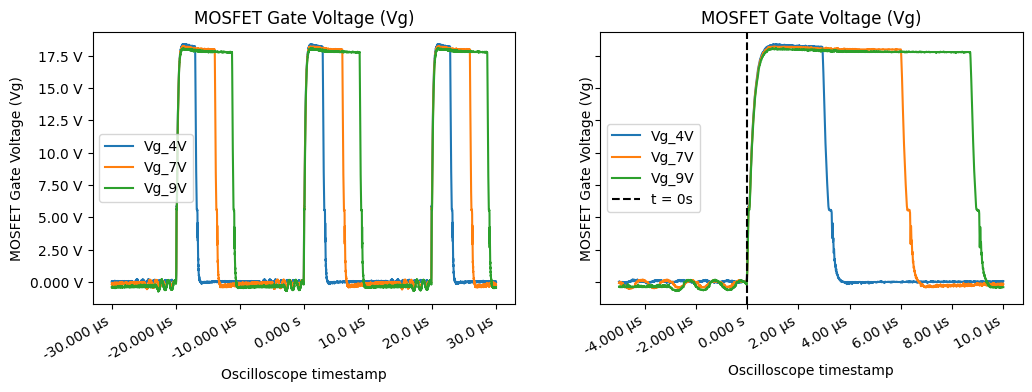

In [78]:
# Vdrain
df_envelope = df
df_zoom = df[(df["t"] > -5e-6) & (df["t"] < 10e-6)]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Gate Voltage (Vg)", "V", title = "MOSFET Gate Voltage (Vg)", ax = ax1)
ax1.plot(df_envelope["t"], df_envelope["Vg_4V"], label = "Vg_4V")
ax1.plot(df_envelope["t"], df_envelope["Vg_7V"], label = "Vg_7V")
ax1.plot(df_envelope["t"], df_envelope["Vg_9V"], label = "Vg_9V")
ax1.legend(loc = "center left")

helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Gate Voltage (Vg)", "V", title = "MOSFET Gate Voltage (Vg)", ax = ax2)
ax2.plot(df_zoom["t"], df_zoom["Vg_4V"], label = "Vg_4V")
ax2.plot(df_zoom["t"], df_zoom["Vg_7V"], label = "Vg_7V")
ax2.plot(df_zoom["t"], df_zoom["Vg_9V"], label = "Vg_9V")
plt.axvline(x = 0, color = "black", linestyle = "dashed", label = "t = 0s")
ax2.legend(loc = "center left")

As expected, the MOSFET gate voltage closely follows the driver pin (since they are only separated by a series resistor).

Non-idealities:
* Small-amplitude ripple leading up to the gate voltage being turned on.
* Very brief pause on the falling edge around 6V.
* Asymptotoic approach to maximum voltage on rising edge, albeit with a relatively fast time constant (<1us).
* Minimum voltage is slightly below zero for larger duty cycles.